In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

2025-03-18 21:14:22.979088: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-18 21:14:23.110860: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742318063.160206   74041 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742318063.175022   74041 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1742318063.286060   74041 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [8]:
# Importing dataset
df = pd.read_csv('15s_Data.csv')
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1,VPN
0,14609555,14609555,14257477,41,53236,2822141,2823216,486985.166667,648067.136364,3.696211,...,6592862,6788103.0,6983344,276112.470129,1056123,1702460.0,2348797,914058.551263,VPN-FT,True
1,14997699,14976002,14976270,34,10,280324,318681,55672.869888,34036.977273,47.407272,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,STREAMING,False
2,14440454,14401292,14401395,959225,959133,960892,960909,960086.133333,960093.000000,2.215997,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
3,14441610,14402929,14403020,959367,958939,960982,961896,960195.266667,960201.333333,2.215819,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
4,14993539,14993539,14778375,152,7,272001,351381,105588.302817,16365.863787,69.830078,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-STREAMING,True


In [9]:
# Data Preprocessing

# Remove duplicate records 
df = df.drop_duplicates()
# Removing records with missing values
df = df.dropna()

# Removing the non-numeric 'class1' column.
features = df.drop(['class1', 'VPN'], axis=1)

# Convert VPN to numeric 0 and 1
target = df['VPN'].map({True: 1, False: 0})

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Split data into training-testing sets
X_rnn = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
X_train, X_test, y_train, y_test = train_test_split(
    X_rnn, target, test_size=0.3, random_state=42, stratify=target
)

In [13]:
# Buildin RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])),  
    tf.keras.layers.SimpleRNN(32, activation='tanh', return_sequences=False),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

I0000 00:00:1742318231.242011   74041 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9517 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,337 (9.13 KB)

 Trainable params: 2,337 (9.13 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Training model
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_split=0.2)


Epoch 1/200


I0000 00:00:1742318268.382866   74780 service.cc:152] XLA service 0x7f9f6c0b8240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742318268.382900   74780 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 SUPER, Compute Capability 8.9
2025-03-18 21:17:48.410639: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742318268.535974   74780 cuda_dnn.cc:529] Loaded cuDNN version 90300


 64/317 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5263 - loss: 0.6937

I0000 00:00:1742318269.039105   74780 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5572 - loss: 0.6758 - val_accuracy: 0.5824 - val_loss: 0.6546
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6027 - loss: 0.6537 - val_accuracy: 0.6033 - val_loss: 0.6458
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6267 - loss: 0.6406 - val_accuracy: 0.6373 - val_loss: 0.6412
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6368 - loss: 0.6355 - val_accuracy: 0.6555 - val_loss: 0.6359
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6408 - loss: 0.6268 - val_accuracy: 0.6258 - val_loss: 0.6290
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6395 - loss: 0.6239 - val_accuracy: 0.6511 - val_loss: 0.6221
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6629 - loss: 0.6136 - val_accuracy: 0.6452 - val_loss: 0.6215
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6482 - loss: 0.6117 - val_accuracy: 0.6416

In [15]:
# Testing model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Accuracy: {str(test_accuracy * 100)[:5]}%")

# Predict probabilities and convert them to class predictions (threshold = 0.5).
y_prob = model.predict(X_test).flatten()
y_pred = (y_prob >= 0.5).astype(int)
print(classification_report(y_test, y_pred))


Testing Accuracy: 74.34%
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      2609
           1       0.78      0.70      0.74      2814

    accuracy                           0.74      5423
   macro avg       0.75      0.75      0.74      5423
weighted avg       0.75      0.74      0.74      5423



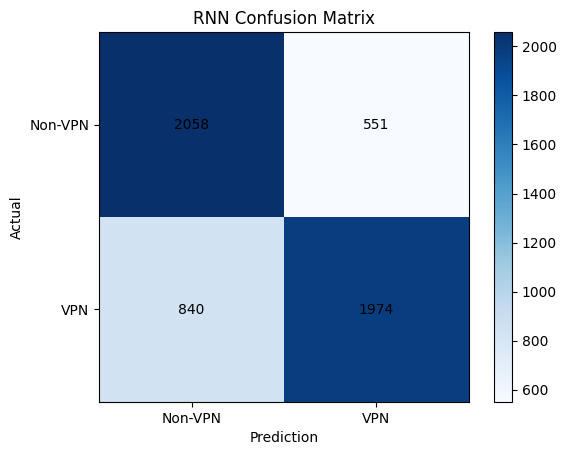

In [16]:
# Plotting Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('RNN Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.colorbar()
plt.xticks([0, 1], ['Non-VPN', 'VPN'])
plt.yticks([0, 1], ['Non-VPN', 'VPN'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
plt.show()


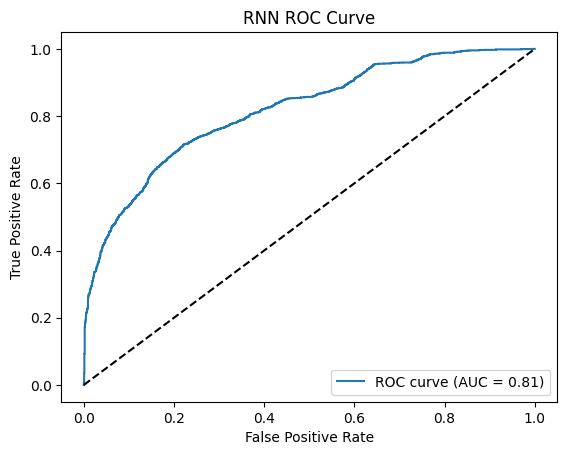

In [17]:
# Plot ROC Curve and Calculate AUC

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {str(roc_auc)[:4]})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('RNN ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()